In [1]:
import random
import time
import datetime
import numpy as np
from numpy import array
import pandas as pd
from pydub import AudioSegment
import os, shutil, glob
import gc
import sys
import h5py
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

#imported for testing
import wave
import contextlib

# for outputing file
import scipy.stats.stats as st

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
import pickle
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from pandas.plotting import parallel_coordinates
import pickle

from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
from keras.constraints import maxnorm
from keras.layers import Add
from keras.models import Sequential
from keras.layers import Dense, Add
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Input
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from keras.utils import np_utils
from keras.utils import to_categorical

from IPython.display import clear_output

import pyprind
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

sample_rate=44100
hop_length = 441  # frame size= 2*hop
segment_length=int(sample_rate*0.2)  #0.2
segment_pad=int(sample_rate*0.02)     #0.02
overlapping=int(sample_rate*0.1)   #0.1

NumofFeaturetoUse = 272 # this will re-assigned for different classifiers
frame_number = 48

try:
    NumofFeaturetoUse = int(sys.argv[1])
    print('Number of features to use is set to ' + str(sys.argv[1]) )
except:
    print('Number of features are unspecified. Defaut is set to = 272.')

Using TensorFlow backend.


Number of features are unspecified. Defaut is set to = 272.


In [3]:
def update_progress(progress):
    bar_length = 100
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
bar = pyprind.ProgBar(1000, monitor=True, title='Progress testing', bar_char='█')
for i in range(1000):
    time.sleep(0.001)
    bar.update()
print(bar)

Progress testing
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Progress testing
  Started: 09/07/2019 21:49:51
  Finished: 09/07/2019 21:49:52
  Total time elapsed: 00:00:01
  CPU %: 9.60
  Memory %: 3.19


In [5]:
def str_to_int(input_np):
    output_np = []
    for x in np.nditer(input_np):
        if x == 'H':
            x = 0
        elif x == 'A':
            x = 1
        elif x == 'N':
            x = 2
        else:
            x = 3
        output_np.append(x)
    output_np = np.array(output_np)
    output_np = np.reshape(output_np, (len(output_np), 1) )
    
    return output_np

def float_compatible(input_np):
    
    input_np = np.nan_to_num(input_np)
    x = np.where(input_np >= np.finfo(np.float32).max)
    
    for index in range(0, len(x[0])):
        
        try:
            x_position = x[0][index]
            y_position = x[1][index]
            input_np[x_position, y_position] = 0.0
        except:
            print(x)
            print(x[0])

    return input_np

In [6]:
def function_FeatureExtractfromSinglewindow(y,hop_length,sr):

    genFeatures=np.array([])
    try:
        mfcc0 = librosa.feature.mfcc(y=y, sr=sr, n_fft=hop_length*2, hop_length=hop_length, n_mfcc=13)
        mfcc=np.transpose(mfcc0)

        genFeatures = np.hstack((genFeatures, np.amin(mfcc, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(mfcc, 0)))
        genFeatures = np.hstack((genFeatures, np.median(mfcc, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(mfcc, 0)))
        genFeatures = np.hstack((genFeatures, np.std(mfcc, 0)))
        genFeatures = np.hstack((genFeatures, np.var(mfcc, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(mfcc, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(mfcc, 0)))
        #print(genFeatures.shape)

        mfcc_delta=librosa.feature.delta(mfcc0)
        mfcc_delta=np.transpose(mfcc_delta)
        genFeatures = np.hstack((genFeatures, np.amin(mfcc_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(mfcc_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.median(mfcc_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(mfcc_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.std(mfcc_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.var(mfcc_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(mfcc_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(mfcc_delta, 0)))
        #print(genFeatures.shape)

        zcr0=librosa.feature.zero_crossing_rate(y=y, frame_length=hop_length*2, hop_length=hop_length)
        zcr=np.transpose(zcr0)
        genFeatures = np.hstack((genFeatures, np.amin(zcr, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(zcr, 0)))
        genFeatures = np.hstack((genFeatures, np.median(zcr, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(zcr, 0)))
        genFeatures = np.hstack((genFeatures, np.std(zcr, 0)))
        genFeatures = np.hstack((genFeatures, np.var(zcr, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(zcr, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(zcr, 0)))
        #print(genFeatures.shape)

        zcr_delta=librosa.feature.delta(zcr0)
        zcr_delta=np.transpose(zcr_delta)
        genFeatures = np.hstack((genFeatures, np.amin(zcr_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(zcr_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.median(zcr_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(zcr_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.std(zcr_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.var(zcr_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(zcr_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(zcr_delta, 0)))
        #print(genFeatures.shape)

        Erms0=librosa.feature.rmse(y=y, frame_length=hop_length*2, hop_length=hop_length)
        Erms=np.transpose(Erms0)
        genFeatures = np.hstack((genFeatures, np.amin(Erms, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(Erms, 0)))
        genFeatures = np.hstack((genFeatures, np.median(Erms, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(Erms, 0)))
        genFeatures = np.hstack((genFeatures, np.std(Erms, 0)))
        genFeatures = np.hstack((genFeatures, np.var(Erms, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(Erms, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(Erms, 0)))
        #print(genFeatures.shape)

        Erms_delta=librosa.feature.delta(Erms0)
        Erms_delta=np.transpose(Erms_delta)
        genFeatures = np.hstack((genFeatures, np.amin(Erms_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(Erms_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.median(Erms_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(Erms_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.std(Erms_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.var(Erms_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(Erms_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(Erms_delta, 0)))
        #print(genFeatures.shape)

        cent0 = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=hop_length*2, hop_length=hop_length)
        cent=np.transpose(cent0)
        genFeatures = np.hstack((genFeatures, np.amin(cent, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(cent, 0)))
        genFeatures = np.hstack((genFeatures, np.median(cent, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(cent, 0)))
        genFeatures = np.hstack((genFeatures, np.std(cent, 0)))
        genFeatures = np.hstack((genFeatures, np.var(cent, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(cent, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(cent, 0)))
        #print(genFeatures.shape)

        cent_delta=librosa.feature.delta(cent0)
        cent_delta=np.transpose(cent_delta)
        genFeatures = np.hstack((genFeatures, np.amin(cent_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(cent_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.median(cent_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(cent_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.std(cent_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.var(cent_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(cent_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(cent_delta, 0)))
        #print(genFeatures.shape)
        #Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

        ############### pitch at certain frame
        pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, fmin=75, fmax=8000, n_fft=hop_length*2, hop_length=hop_length)
        p=[pitches[magnitudes[:,i].argmax(),i] for i in range(0,pitches.shape[1])]
        pitch0=np.array(p)   #shape (305,)
        pitch=np.transpose(pitch0)
        genFeatures = np.hstack((genFeatures, np.amin(pitch, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(pitch, 0)))
        genFeatures = np.hstack((genFeatures, np.median(pitch, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(pitch, 0)))
        genFeatures = np.hstack((genFeatures, np.std(pitch, 0)))
        genFeatures = np.hstack((genFeatures, np.var(pitch, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(pitch, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(pitch, 0)))
        #print(genFeatures.shape)

        pitch_delta=librosa.feature.delta(pitch0)
        pitch_delta=np.transpose(pitch_delta)
        genFeatures = np.hstack((genFeatures, np.amin(pitch_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.amax(pitch_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.median(pitch_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.mean(pitch_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.std(pitch_delta, 0)))
        genFeatures = np.hstack((genFeatures, np.var(pitch_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.skew(pitch_delta, 0)))
        genFeatures = np.hstack((genFeatures, st.kurtosis(pitch_delta, 0)))
    except Exception as e:
        print(e)
    #print(genFeatures.shape)    #272
    return genFeatures

In [7]:
'''
Extract specified amount of features from an audio file
'''
def function_FeatureExtract1(audiofile, NumofFeatures):
    extension = '.wav'
    flag_start_all = 0
    flag_Y_start = 0
    All = np.array([])
    NumofFeaturetoUse = NumofFeatures #needs to be reassigned, takes two parameters
    ListOfFrame2Vec = np.empty((0, frame_number, NumofFeaturetoUse))
    audio, s_rate = librosa.load(audiofile, sr=sample_rate)
    segment_start_flag = 0
    start_seg = 0
    while (start_seg + segment_length) < len(audio):
        flag = 1
        sound1 = audio[start_seg:(start_seg + segment_length)]

        featureSet = function_FeatureExtractfromSinglewindow(sound1, hop_length, sample_rate)

        if segment_start_flag == 0:
            SegAllFeat = featureSet
            segment_start_flag = 1
        else:
            SegAllFeat = np.vstack((SegAllFeat, featureSet))

        start_seg = start_seg + overlapping

    if segment_start_flag == 1:
        #print(SegAllFeat.shape)
        SegAllFeat = normalize(SegAllFeat, norm='l2', axis=0)

    #print(SegAllFeat.shape)
    if flag_start_all == 0:
        All = SegAllFeat
        flag_start_all = 1
    else:
        All = np.vstack((All, SegAllFeat))

    return All

In [17]:
# these funstion will generate feature set for feature selection from training
def function_FeatureExtract(path, classY):
    extension = '.wav'
    
    flag_start_all = 0
    flag_Y_start = 0
    file_counter = 1
    
    All = np.array([])
    ClassLabel = np.array([])
    
    #bar = pyprind.ProgBar(len(os.listdir(path)), monitor=True, title='feature extraction', bar_char='█')
    
    number_of_elements = len(os.listdir(path))
    i = 0
    for file_name in os.listdir(path):
        
        if not file_name.endswith(extension) or file_name[0] == '.':
            continue
        
        try:
            audiofile = path + file_name
            audio, s_rate = librosa.load(audiofile, sr=sample_rate)
            segment_start_flag = 0
            start_seg = 0

            while (start_seg + segment_length) < len(audio):

                flag = 1
                sound1 = audio[start_seg:(start_seg + segment_length)]
                featureSet = function_FeatureExtractfromSinglewindow(sound1, hop_length, sample_rate)

                featureSet = float_compatible(featureSet)

                if segment_start_flag == 0:
                    SegAllFeat = featureSet
                    SegAllFeat = float_compatible(SegAllFeat)
                    segment_start_flag = 1
                else:
                    SegAllFeat = float_compatible(SegAllFeat)
                    SegAllFeat = np.vstack((SegAllFeat, featureSet))


                if flag_Y_start == 0:
                    ClassLabel = [classY]
                    flag_Y_start = 1
                else:
                    ClassLabel = np.vstack((ClassLabel, [classY]))

                ################################ end of class value identify
                start_seg = start_seg + overlapping

            SegAllFeat = float_compatible(SegAllFeat)
            #print(SegAllFeat.shape)
            if segment_start_flag == 1:
                try:
                    SegAllFeat = normalize(SegAllFeat, norm='l2', axis=0)
                except:
                    x = np.where(SegAllFeat >= np.finfo(np.float32).max)
                    print(x)
                    break

            #print(SegAllFeat.shape)
            if flag_start_all == 0:
                All = SegAllFeat
                flag_start_all = 1
            else:
                All = np.vstack((All, SegAllFeat))

            i += 1
            update_progress(i / number_of_elements)
        except:
            pass

    return All, ClassLabel

In [18]:
def obtain_new_feature_vector(feature_raw, feature_vector, label, label_vector):
    
    # feature_raw = the path in which the raw files (images, audios) are saved.
    # feature_vector = the npy file consisting of all the feature vectors in the class
    # label = the label of the class, should be numerical,  a single number
    # label_vector = just an npy array of the labels
    
    if os.path.exists(feature_vector):
        print('Deleting old feature vector npy ...')
        os.remove(feature_vector)
        
    if os.path.exists(label_vector):
        print('Deleting old label vector npy ...')
        os.remove(label_vector)
    
    open(feature_vector, 'a').close()
    open(label_vector, 'a').close()
    
    featureSet, Label = function_FeatureExtract(feature_raw, label)  # change here
    
    np.save(feature_vector, featureSet)
    np.save(label_vector, Label)


    vec = featureSet/np.float32(255)
    # label = Label.astype(np.int32)  # not required
    
    return np.array(vec), np.array(label)

In [19]:
def load_old_feature_vector(feature_vector, label_vector):
    
    # feature_raw = the path in which the raw files (images, audios) are saved.
    # feature_vector = the npy file consisting of all the feature vectors in the class
    # label = the label of the class, should be numerical,  a single number
    # label_vector = just an npy array of the labels
    vec = np.array([])
    ret_label = np.array([])
    
    if not os.path.exists(feature_vector):
        print('Unable to find old feature vector npy ...')
        
    elif not os.path.exists(label_vector):
        print('Unable to find old label vector npy ... ')

    else:
        vec = np.load(feature_vector)
        ret_label = np.load(label_vector)

    return np.array(vec), np.array(label)

In [20]:
prefix = '//Volumes//Morpheus//'

h_directory = prefix + 'Datasets//TRAINING//Happy//'
a_directory = prefix + 'Datasets//TRAINING//Angry//'
n_directory = prefix + 'Datasets//TRAINING//Neutral//'
s_directory = prefix + 'Datasets//TRAINING//Sad//'
o_directory = prefix + 'Datasets//TRAINING//Other//'

h_test = prefix + 'Datasets//TRAINING//Happy_test//'
a_test = prefix + 'Datasets//TRAINING//Angry_test//'
n_test = prefix + 'Datasets//TRAINING//Neutral_test//'
s_test = prefix + 'Datasets//TRAINING//Sad_test//'
o_test = prefix + 'Datasets//TRAINING//Other_test//'

background_noise = 'D://Background_noise//TUT2016//'
background_noise_test = 'D://Background_noise//noise_test//'

emotion_train_folders = [h_directory, a_directory, n_directory, s_directory, o_directory]
emotion_test_folders = [h_test, a_test, n_test, s_test, o_test]

In [22]:
prefix = '..//..//'

h_feature_vector = np.load(prefix + 'Features//h_feature_vector_indices.npy')
h_label_vector = np.load(prefix + 'Features//h_label_vector_indices.npy')

a_feature_vector = np.load(prefix + 'Features//a_feature_vector_indices.npy')
a_label_vector = np.load(prefix + 'Features//a_label_vector_indices.npy')

n_feature_vector = np.load(prefix + 'Features//n_feature_vector_indices.npy')
n_label_vector = np.load(prefix + 'Features//n_label_vector_indices.npy')

s_feature_vector = prefix + 'Features//s_feature_vector_indices.npy'
s_label_vector = prefix + 'Features//s_label_vector_indices.npy'

o_feature_vector = prefix + 'Features//o_feature_vector_indices.npy'
o_label_vector = prefix + 'Features//o_label_vector_indices.npy'

h_feature_vector_test = prefix + 'Features//h_feature_vector_test_indices.npy'
h_label_vector_test = prefix + 'Features//h_label_vector_test_indices.npy'

a_feature_vector_test = prefix + 'Features//a_feature_vector_test_indices.npy'
a_label_vector_test = prefix + 'Features//a_label_vector_test_indices.npy'

n_feature_vector_test = prefix + 'Features//n_feature_vector_test_indices.npy'
n_label_vector_test = prefix + 'Features//n_label_vector_test_indices.npy'

s_feature_vector_test = prefix + 'Features//s_feature_vector_test_indices.npy'
s_label_vector_test = prefix + 'Features//s_label_vector_test_indices.npy'

o_feature_vector_test = prefix + 'Features//o_feature_vector_test_indices.npy'
o_label_vector_test = prefix + 'Features//o_label_vector_test_indices.npy'

indices_npy_five = prefix + 'Features//feat_ranking_five_classes.npy'
indices_npy_four = prefix + 'Features//feat_ranking_four_classes.npy'
indices_npy_binary_top = prefix + 'Features//feat_ranking_binary_top.npy'
indices_npy_binary_H_A = prefix + 'Features//feat_ranking_binary_H_A.npy'
indices_npy_binary_N_S = prefix + 'Features//feat_ranking_binary_N_S.npy'
indices_npy_tri_top_O = prefix + 'Features//feat_ranking_tri_top_O.npy'
indices_npy_tri_H_A_O = prefix + 'Features//feat_ranking_tri_H_A_O.npy'
indices_npy_tri_N_S_O = prefix + 'Features//feat_ranking_tri_N_S_O.npy'

In [23]:
#data_test_s, label_test_s = obtain_new_feature_vector(s_test, s_feature_vector_test, 3, s_label_vector_test)

In [24]:
#data_train_s, label_train_s = obtain_new_feature_vector(s_directory, s_feature_vector, 3, s_label_vector)

In [25]:
#data_test_o, label_test_o = obtain_new_feature_vector(o_test, o_feature_vector_test, 4, o_label_vector_test)

In [26]:
data_train_o, label_train_o = obtain_new_feature_vector(o_directory, o_feature_vector, 4, o_label_vector)

Progress: [####################################################################################################] 100.0%


In [28]:
h_feature_vector_test = np.load(prefix + 'Features//h_feature_vector_test_indices.npy')
h_label_vector_test = np.load(prefix + 'Features//h_label_vector_test_indices.npy')

a_feature_vector_test = np.load(prefix + 'Features//a_feature_vector_test_indices.npy')
a_label_vector_test = np.load(prefix + 'Features//a_label_vector_test_indices.npy')

train_data = np.vstack((h_feature_vector, a_feature_vector))
train_labels = np.vstack((h_label_vector, a_label_vector))
indices_file = indices_npy_binary_H_A

In [29]:
def feature_ranking(indices_file):
    
    if os.path.exists(indices_file):
        print('Deleting indices npy ...')
        os.remove(indices_file)
    open(indices_file, 'a').close()
    
    featureSet = train_data.astype(np.float32)
    Label = train_labels.astype(np.float32)

    ############################################################ feature selection
    
    X, X_test, Y, Y_test= train_test_split(featureSet, Label, test_size=0.25)
    seed = 7
    num_trees = 272

    forest = RandomForestClassifier(n_estimators=num_trees)

    forest.fit(X,Y)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    np.save(indices, indices_file)

    return indices

    ############## whole code is random forest based feature selection

Feature ranking:
1. feature 13 (0.019585)
2. feature 39 (0.015058)
3. feature 26 (0.014274)
4. feature 0 (0.010394)
5. feature 258 (0.006100)
6. feature 226 (0.005939)
7. feature 45 (0.005899)
8. feature 227 (0.005643)
9. feature 14 (0.005590)
10. feature 195 (0.005534)
11. feature 225 (0.005491)
12. feature 32 (0.005481)
13. feature 78 (0.005451)
14. feature 6 (0.005440)
15. feature 263 (0.005394)
16. feature 27 (0.005393)
17. feature 40 (0.005387)
18. feature 239 (0.005379)
19. feature 91 (0.005300)
20. feature 197 (0.005296)
21. feature 215 (0.005274)
22. feature 255 (0.005258)
23. feature 93 (0.005250)
24. feature 223 (0.005238)
25. feature 198 (0.005218)
26. feature 201 (0.005184)
27. feature 100 (0.005171)
28. feature 101 (0.005159)
29. feature 199 (0.005145)
30. feature 231 (0.005143)
31. feature 203 (0.005134)
32. feature 247 (0.005134)
33. feature 202 (0.005112)
34. feature 182 (0.005109)
35. feature 196 (0.005092)
36. feature 204 (0.005088)
37. feature 95 (0.005085)
38. featu

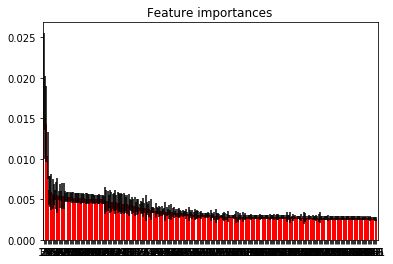

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [30]:
x = feature_ranking(indices_file)

In [ ]:
x = feature_ranking(indices_file)
np.save(indices_file, x)

Deleting indices npy ...


In [ ]:
n_feature_vector_test = np.load(prefix + 'Features//n_feature_vector_test_indices.npy')
s_label_vector_test = np.load(prefix + 'Features//s_label_vector_test_indices.npy')

n_feature_vector_test = np.load(prefix + 'Features//n_feature_vector_test_indices.npy')
s_label_vector_test = np.load(prefix + 'Features//s_label_vector_test_indices.npy')

train_data = np.vstack((n_feature_vector, s_feature_vector))
train_labels = np.vstack((n_label_vector, s_label_vector))
indices_file = indices_npy_binary_N_S

In [ ]:
x = feature_ranking(indices_file)
np.save(indices_file, x)

In [ ]:
'''
featureSet_val=np.vstack((featureSet_validation0, featureSet_validation1))
Label_val=np.append(Label_validation0, Label_validation1, axis=0)

featureSet=np.vstack((featureSet_train0, featureSet_train1))
Label=np.append(Label_train0, Label_train1, axis=0)
'''